In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
class Node:
	'''
	Represents a node in the communication network.
	'''
	def __init__(self, id: int, initial_value: int):
		self.id = id
		self.value = initial_value
		self.values = [initial_value]

	def __str__(self):
		return (f'Node {self.id} with value {self.values[-1]}')

	def reset(self):
		self.value = self.values[0]
		self.values = [self.value]

In [14]:
class Graph:
	'''
	Represents a bidirectional graph with nodes that have values.
	'''
	def __init__(self, A: np.ndarray, title: str, initial_values: np.ndarray):
		if A.shape[0] != A.shape[1]:
			raise ValueError("Adjacency matrix must be square")
		self.A = A
		self.label = title
		self.nx_graph = nx.from_numpy_array(A)
		self.nodes = [Node(i, initial_values[i]) for i in range(A.shape[0])]

	def __str__(self):
		str = '['
		for node in self.nodes:
			str += f'{node.values[-1]} '
		str += ']'
		return str

	def plot_self(self):
		'''
		Draws the shape of the graph.
		'''
		nx.draw(self.nx_graph, with_labels=True)
		plt.show()

	def plot_values(self):
		'''
		Plots the values of each node over time.
		'''
		for node in self.nodes:
			plt.plot(node.values, label=f'Node {node.id}')
		plt.xlabel('Time')
		plt.ylabel('Value')
		plt.title(self.label)
		plt.legend()
		plt.show()

	def broadcast_to_neighbors(self, initiator: int):
		'''
		Broadcasts the value of the given node to its neighbors. The neighbors average their values with the value of the given node.
		'''
		neighbors = np.array(self.nx_graph[initiator])
		for neighbor in neighbors:
			self.nodes[neighbor].value = (self.nodes[neighbor].value + self.nodes[initiator].value) / 2

	def receive_from_neighbors(self, initiator: int):
		'''
		Receives the values of the given node's neighbors and averages them with the value of the given node.
		'''
		neighbors = np.array(self.nx_graph[initiator])
		received_values = np.array([self.nodes[from_node].value for from_node in neighbors])
		self.nodes[initiator].value = (self.nodes[initiator].value + np.sum(received_values)) / (len(neighbors) + 1)

	def track_current_values(self, nodes=None):
		'''
		Adds the current value to a list of values for each node to keep track of its change over time.
		'''
		if nodes == None:
			nodes = self.nodes
		for node in nodes:
			node.values.append(node.value)

	def add_rewards(self, node_ids: np.ndarray, rewards: np.ndarray):
		'''
		Adds the given rewards to the values of the given nodes.
		'''
		if node_ids.shape != rewards.shape:
			raise ValueError("Node ids and rewards must have the same shape")
		for id, reward in zip(node_ids, rewards):
			self.nodes[id].value += reward

	def reset(self):
		'''
		Resets the values of all nodes to their initial values.
		'''
		for node in self.nodes:
			node.reset()

In [15]:
num_nodes = 5
networks = [
	{
		'shape': 'All-to-all',
		'A': nx.to_numpy_array(nx.complete_graph(num_nodes))
	},
	{
		'shape': 'ring',
		'A': nx.to_numpy_array(nx.cycle_graph(num_nodes))
	},
	{
		'shape': 'star',
		'A': nx.to_numpy_array(nx.balanced_tree(4, 1))
	},
]

51


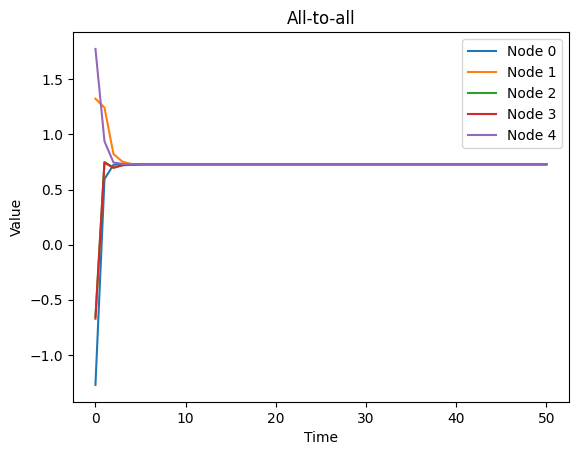

51


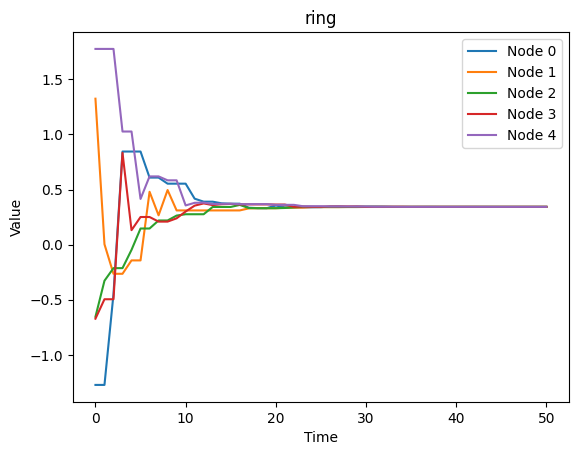

51


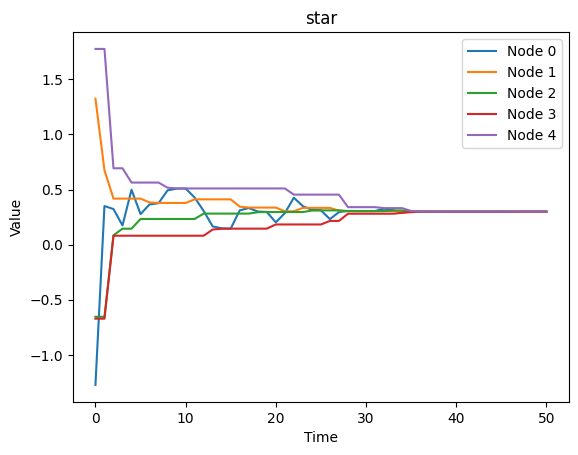

In [19]:
initial_values = np.random.normal(0, 1, num_nodes)

# LAIE
for network in networks:
	G = Graph(network['A'], title=network['shape'], initial_values=initial_values)
	for i in range(50):
		initiator = np.random.randint(0, network['A'].shape[0])
		G.broadcast_to_neighbors(initiator)
		G.receive_from_neighbors(initiator)
		G.broadcast_to_neighbors(initiator)
		G.track_current_values()
	print(len(G.nodes[0].values))
	G.plot_values()